In [7]:
import numpy as np
import czifile
from pathlib2 import Path
import matplotlib.pyplot as plt
import cv2
from fil_finder import FilFinder2D
import astropy.units as u
import pandas as pd
from tqdm.notebook import tqdm

In [8]:
project_dir = Path('../../../data/2021.02.16')
result_dir = project_dir / 'result_dir'
data_dir = project_dir / 'input_data'
px2mum_mult = 600 / 2048

In [9]:
from forest import prepare_mask, make_skeleton, make_forest

In [10]:
def find_branching_points(skeleton):
    import scipy
    kernel = np.ones((3, 3), 'uint8')
    neighbors = cv2.filter2D((skeleton > 0).astype('uint8'), -1, kernel)
    high_degree = (skeleton > 0) & (neighbors >= 4)
    
    contours,hier = cv2.findContours(high_degree.astype('uint8'),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    branching_points = np.zeros_like(skeleton, dtype='bool')
    for cnt in contours:
        assert(cnt.shape[1] == 1)
        cnt = np.squeeze(cnt, axis = 1)
        w = scipy.spatial.distance.pdist(cnt)
        cid = np.argmin(w.sum(axis = 0))
        branching_points[cnt[cid, 1], cnt[cid, 0]] = 1
    return branching_points

def make_forest_image(img, mask, skeleton):
    import cmapy
    img = np.minimum(img / np.quantile(img, 0.999) * 256, 255)
    res = cv2.applyColorMap(img.astype('uint8'), cmapy.cmap('gray'))
    
    contours, hierarchy = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(res, contours, -1, (0,80,0), 1)

    res[skeleton != 0, :] = 0
    res[skeleton != 0, 2] = 80
    
    branching_points = find_branching_points(skeleton)
    res[branching_points, :] = 0
    res[branching_points, 1:3] = 255
    
    return res

def analyze_stack(czi_filename):
    im = czifile.imread(czi_filename)
    #print(czi_filename.name, im.shape)
    im = im.reshape(im.shape[3:6])
    
    from forest import make_forest
    all_forests = []
    for i in tqdm(range(len(im))):
        img = im[i, :, :].copy()
        mask, skeleton, dist = make_forest(img)
        forest_img = make_forest_image(img, mask, skeleton)
        #print(forest_img.shape, forest_img.dtype)

        forest_img_filename = result_dir / 'forest_images' / (czi_filename.stem + '_' + str(i) + '.png')
        forest_img_filename.parent.mkdir(parents=True, exist_ok=True)
        #print(forest_img_filename)

        #cv2.imwrite(str(forest_img_filename), forest_img)
        all_forests.append([mask, skeleton, dist, forest_img])
        #break

    forests_img_filename = result_dir / 'forests' / (czi_filename.stem + '.npy')
    forests_img_filename.parent.mkdir(parents=True, exist_ok=True)
    #print(all_forests)
    #np.save(forests_img_filename, all_forests, allow_pickle = True)
    return all_forests


In [11]:
data = [
    ("Young1.czi", "young"),
    ("Old1.czi", "old"),
    ("Old2.czi", "old"),
    ("Old3.czi", "old"),
    ("Old4.czi", "old"),
]

In [12]:
all_data = []
for czi in tqdm(data):
    czi_filename = data_dir / czi[0]
    all_data.append(analyze_stack(czi_filename))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

In [13]:
for i in range(len(data)):
    np.save(result_dir / (data[i][0] + '.npy'), np.array([all_data[i], 0], dtype=object))

In [14]:
all_data = []
for i in tqdm(range(len(data))):
    cur_data, _ = np.load(result_dir / (data[i][0] + '.npy'), allow_pickle = True)
    all_data += [cur_data]

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
len(all_data), type(all_data)

(5, list)

In [16]:
mask, skeleton, dist, forest_img = all_data[0][0]

'\nplt.figure(figsize = (20, 20))\nplt.imshow(dist)\nplt.colorbar()\n\nplt.figure(figsize = (20, 20))\nplt.imshow(mask)\nplt.colorbar()\n\nplt.figure(figsize = (20, 20))\nplt.imshow(skeleton)\nplt.colorbar()\n'

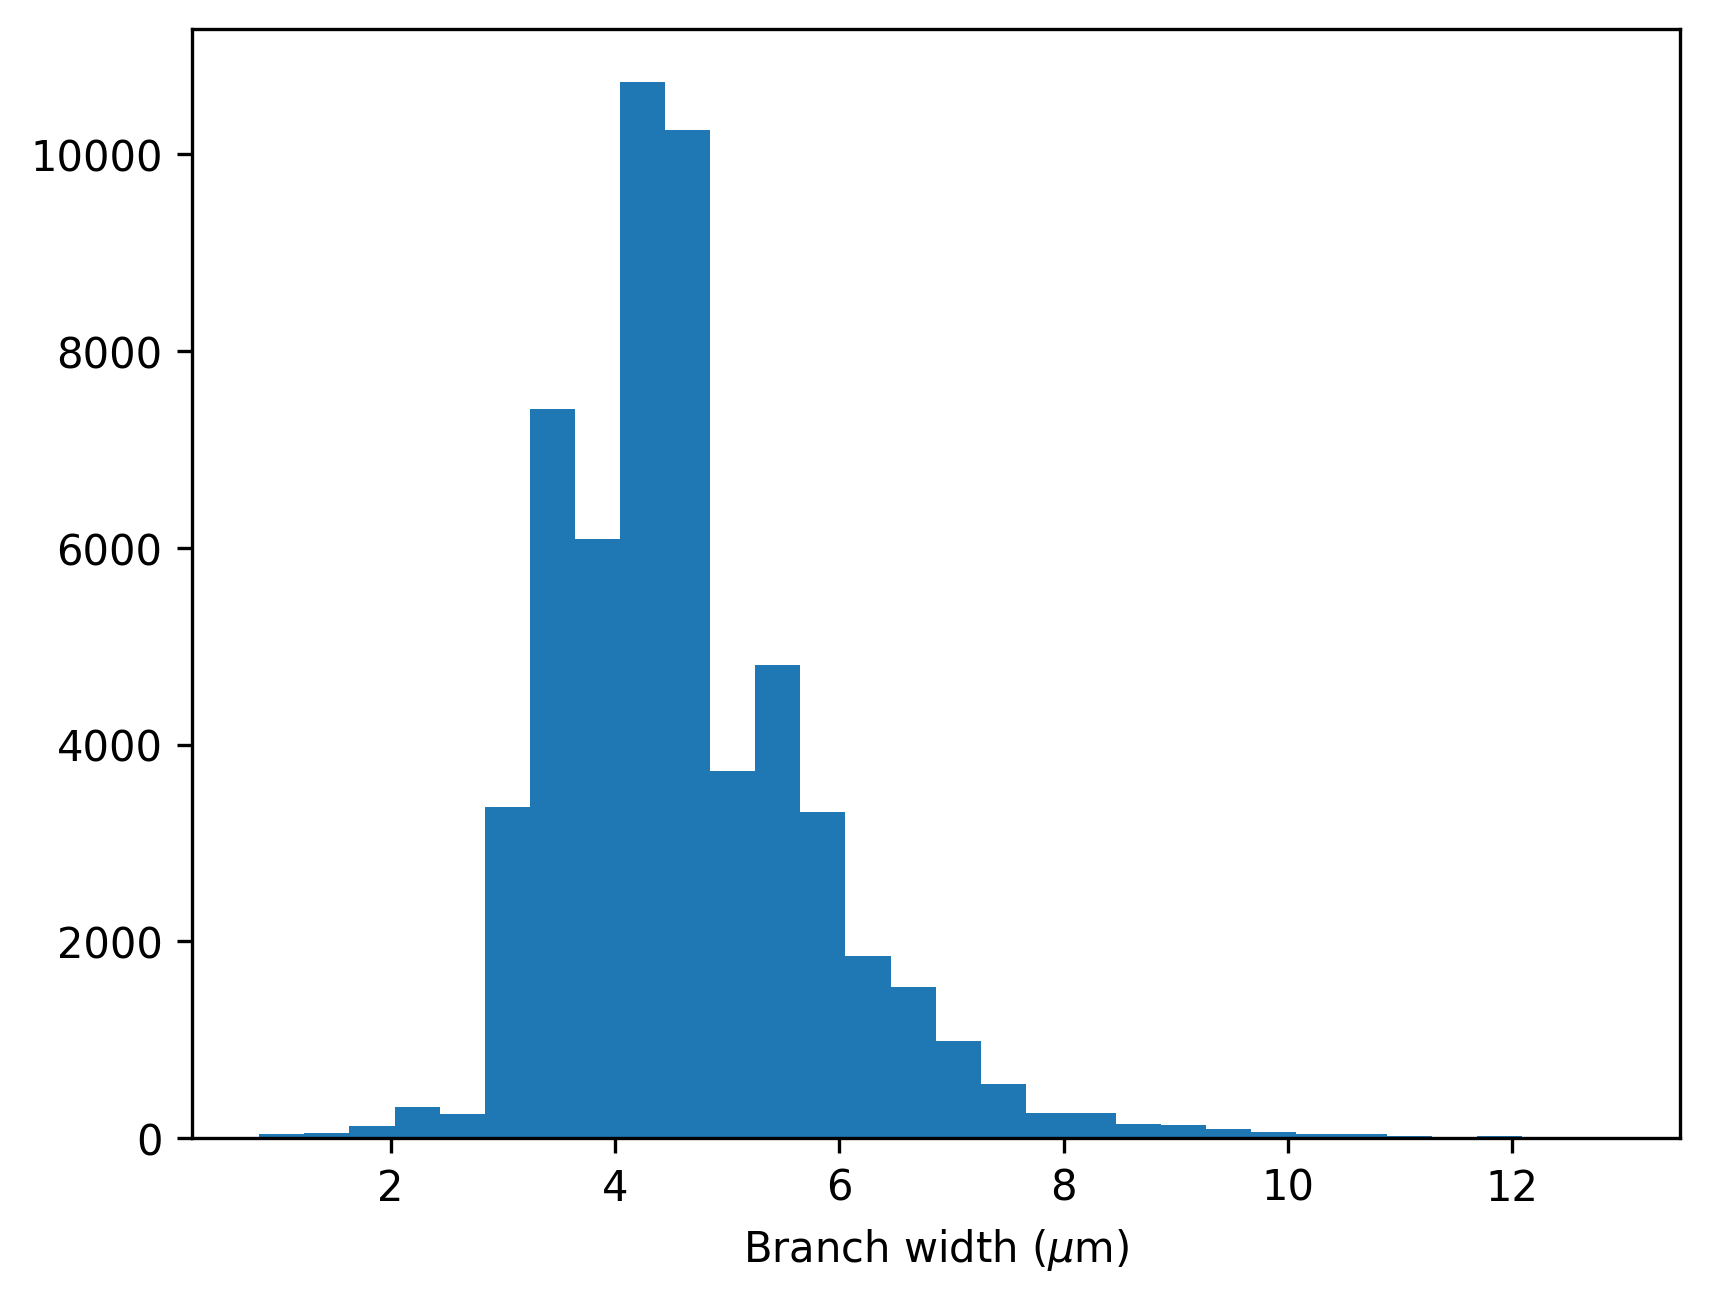

In [17]:
plt.figure(dpi = 300)
branch_widths = dist[dist > 0] * 2 * px2mum_mult
plt.hist(branch_widths, bins = 30)
plt.xlabel('Branch width ($\mu$m)')

'''
plt.figure(figsize = (20, 20))
plt.imshow(dist)
plt.colorbar()

plt.figure(figsize = (20, 20))
plt.imshow(mask)
plt.colorbar()

plt.figure(figsize = (20, 20))
plt.imshow(skeleton)
plt.colorbar()
'''

In [18]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#cmapy.cmap('viridis').shape

In [19]:
import igraph

In [20]:
from numba import njit, jit
import numba as nb

@jit(nb.types.containers.UniTuple(nb.types.containers.List(nb.types.containers.UniTuple(nb.types.int64, 2)), 2)
    (
        nb.types.types.uint8[:, ::1], 
        nb.types.types.int64[:, ::1],
        nb.types.types.boolean[:, ::1]
    ),
    nopython=True
)
def bfs(skeleton, pos_branching, branching_points):
    short_edges = [(0, 0)] * 0
    full_edges = [(0, 0)] * 0
    
    was = np.zeros_like(skeleton, 'bool')
    get_id = lambda x, y, n: x * n + y
    n = skeleton.shape[0]
    
    for x, y in pos_branching.T:
        q = [(x, y, x, y)]
        get_id(x, y, n)
        l = 0
        
        while l < len(q):
            x, y, bx, by = q[l]
            if branching_points[x, y]:
                bx, by = x, y
            for cx in x - 1, x, x + 1:
                for cy in y - 1, y, y + 1:
                    if 0 <= cx < skeleton.shape[0] and 0 <= cy < skeleton.shape[1] and skeleton[cx, cy]: #and (cx, cy) != (x, y)
                        if branching_points[cx, cy]:
                            if (bx, by) != (cx, cy):
                                short_edges += [(get_id(bx, by, n), get_id(cx, cy, n))]
                        full_edges += [(get_id(x, y, n), get_id(cx, cy, n))]
                        if not was[cx][cy]:
                            q += [(cx, cy, bx, by)]
                            was[cx][cy] = True
            l += 1
    return short_edges, full_edges
bfs.disable_compile()

In [21]:
branching_points = find_branching_points(skeleton)
branching_mask = branching_points > 0
pos_branching = np.array(np.nonzero(branching_mask))
short_edges, full_edges = bfs(skeleton, pos_branching, branching_points)

In [22]:
def make_network(skeleton, dist):
    from time import time
    
    branching_points = find_branching_points(skeleton)
    
    widths = dist[branching_points] * 2 * px2mum_mult
    skeleton_mask = skeleton > 0
    
    ids_skeleton = np.flatnonzero(skeleton_mask)
    pos_skeleton = np.nonzero(skeleton_mask)
    ids_not_skeleton = np.flatnonzero(~skeleton_mask)
    
    g_full = igraph.Graph()
    g_full.add_vertices(skeleton.size)
    
    branching_mask = branching_points > 0

    ids_branching = np.flatnonzero(branching_mask)
    pos_branching = np.nonzero(branching_mask)
    ids_not_branching = np.flatnonzero(~branching_mask)
    
    g_short = igraph.Graph()
    g_short.add_vertices(skeleton.size)
    
    short_edges, full_edges = bfs(skeleton, np.array(pos_branching), branching_points)
    
    g_short.add_edges(list(set(short_edges)))
    g_full.add_edges(list(set(full_edges)))
    
    g_short.delete_vertices(ids_not_branching)
    g_full.delete_vertices(ids_not_skeleton)
    
    g_short.vs['pos'] = list(zip(*pos_branching))
    g_full.vs['pos'] = list(zip(*pos_skeleton))
    
    return g_short, g_full
g_short, g_full = make_network(skeleton, dist)

In [23]:
g_full.ecount(), skeleton.sum(), g_short.ecount()

(154652, 56513, 890)

In [24]:
def compute_network_statistics(g):
    df_network_metrics = pd.DataFrame()
    df_network_metrics['degree'] = g.degree()
    df_network_metrics['closeness'] = g.closeness()
    df_network_metrics['betweenness'] = g.betweenness()
    df_network_metrics['harmonic_centrality'] = g.harmonic_centrality()
    df_network_metrics['hub_score'] = g.hub_score()
    df_network_metrics['harmonic_centrality'] = g.harmonic_centrality()
    #df_network_metrics['harmonic_centrality'] = g.harmonic_centrality()
    df_network_statistics = df_network_metrics.describe()
    df_network_statistics = df_network_statistics.rename(index={'25%': 'Q1', '50%': 'median', '75%': 'Q3'})
    df_network_statistics = df_network_statistics.drop(index='count')
    df_network_statistics = df_network_statistics.stack().reset_index()
    #df_network_statistics['level_0'].str + '_' + df_network_statistics['level_1'].str
    df_network_statistics['feature_name'] = \
        df_network_statistics.apply(lambda x: x['level_0'] + '_' + x['level_1'], axis=1)
    
    df_network_statistics = df_network_statistics.drop(columns = ['level_0', 'level_1'])
    df_network_statistics = df_network_statistics.rename(columns={0: 'value'})
    df_network_statistics = df_network_statistics.set_index('feature_name')
    df_network_statistics = df_network_statistics.T.reset_index()

    clustering = g.connected_components()
    network_info = {
        'modularity': clustering.modularity,
        'connected_components': clustering.sizes(),
        'diameters': g.get_diameter(),
        'vertex_count': g.vcount(),
        'edge_count': g.ecount(),
        'girth': g.girth(), # the length of the shortest circle
        'reciprocity': g.reciprocity(),
        'transitivity_undirected': g.transitivity_undirected(),
    }

    network_info['max_connected_components'] = np.max(network_info['connected_components'])
    network_info['mean_connected_components'] = np.mean(network_info['connected_components'])
    network_info['cnt_connected_components'] = len(network_info['connected_components'])
    for feature_name, value in network_info.items():
        if isinstance(value, (int, float)):
            df_network_statistics.loc[0, feature_name] = value

    return df_network_metrics, df_network_statistics
#g = g_short_small.copy()
#df_network_metrics, df_network_statistics = compute_network_statistics(g)
#print(df_network_statistics.T)


In [25]:
g_short_small = g_short.copy()
to_delete_ids = [v.index for v in g_short_small.vs if v.degree() == 0]
g_short_small.delete_vertices(to_delete_ids)
print(len(to_delete_ids))

88


<AxesSubplot: >

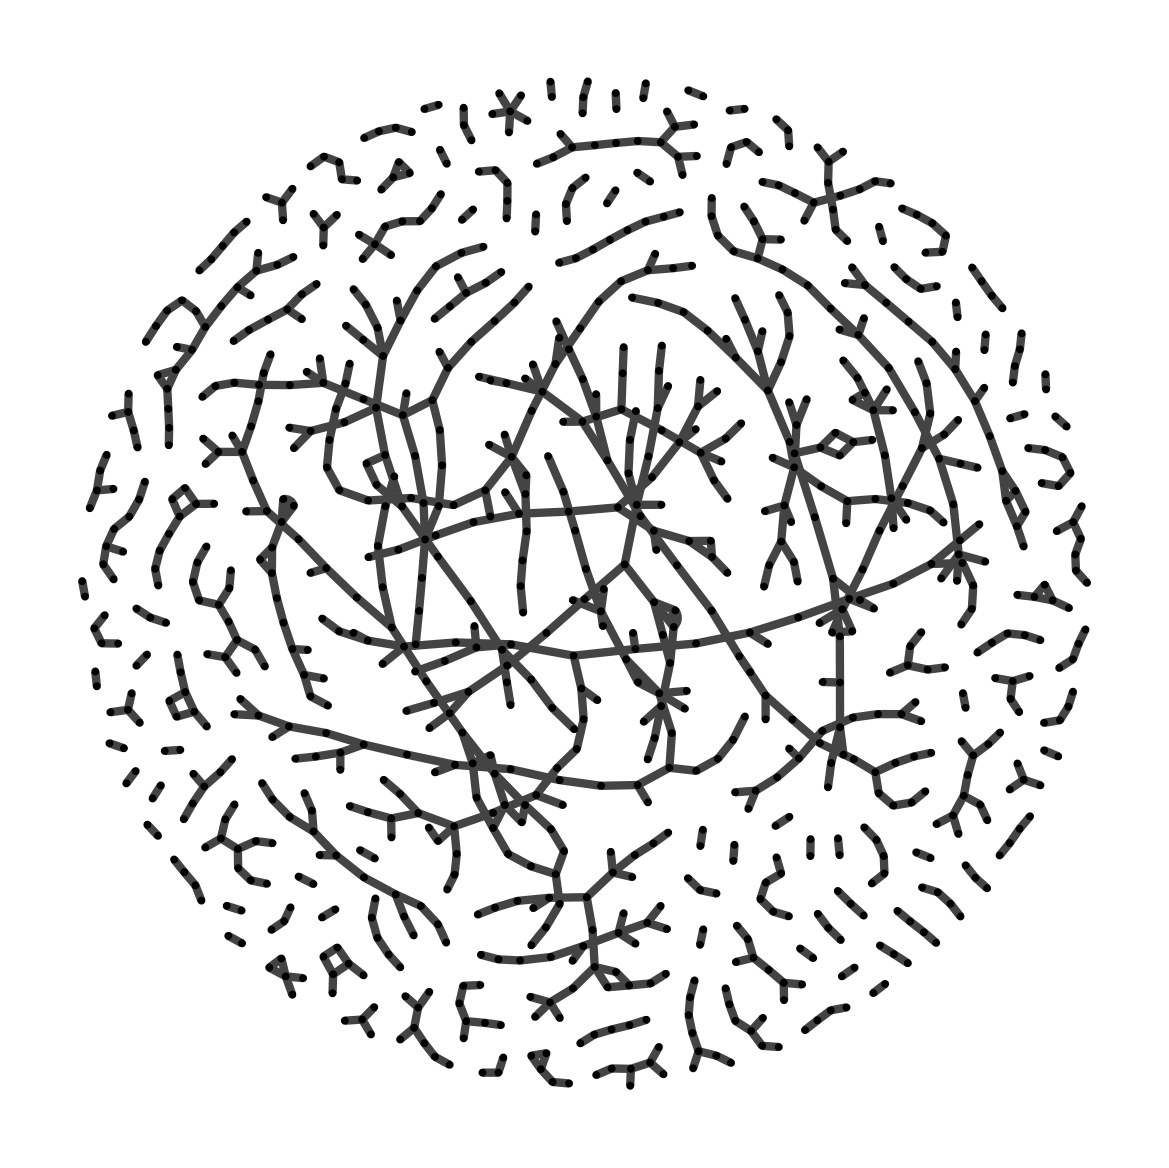

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300)
igraph.plot(g_short_small, target=ax)

In [27]:
g_short_small.vcount(), g_short_small.ecount()

(994, 890)

In [28]:
def get_distances(all_data):
    all_dist = []
    mean_dist = []
    for i in range(len(all_data)):
        cur_dist = []
        cur_mean_dist = []
        for j in range(len(all_data[i])):
            mask, skeleton, dist, forest_img = all_data[i][j]
            cdist = dist[dist != 0] * 2 * px2mum_mult
            cur_dist.append(cdist)
            cur_mean_dist.append(cdist.mean())
        mean_dist.append(cur_mean_dist)
        all_dist.append(np.concatenate(cur_dist))
    return all_dist, mean_dist

def get_area(all_data, normalized = False):
    all_area = []
    for i in range(len(all_data)):
        cur_area = []
        for j in range(len(all_data[i])):
            mask, skeleton, dist, forest_img = all_data[i][j]
            if normalized:
                cur_area.append([mask.mean()])
            else:
                cur_area.append([mask.sum()])
        all_area.append(np.concatenate(cur_area))
    return all_area

def get_branching_points(all_data):
    all_branching = []
    all_branching_width = []
    all_mean_width = []
    for i in range(len(all_data)):
        cur_branching = []
        cur_width = []
        cur_mean_width = []
        for j in range(len(all_data[i])):
            mask, skeleton, dist, forest_img = all_data[i][j]
            
            branching_points = find_branching_points(skeleton)
            widths = dist[branching_points] * 2 * px2mum_mult
            widths = widths
            cur_width.append(widths)
            cnt_branching = (branching_points).sum()
            cur_branching.append([cnt_branching])
            cur_mean_width.append(widths.mean())
            
        all_branching.append(np.concatenate(cur_branching))
        all_branching_width.append(np.concatenate(cur_width))
        all_mean_width.append(cur_mean_width)
        
    return all_branching, all_branching_width, all_mean_width

from tqdm.notebook import tqdm
def get_networks(all_data):
    all_network_shorts = []
    all_network_full = []
    all_network_statistics = []
    for i in tqdm(range(len(all_data))):
        cur_shorts = []
        cur_full = []
        cur_network_statistics = []
        cur_network_statistics = []
        for j in tqdm(range(len(all_data[i]))):
            mask, skeleton, dist, forest_img = all_data[i][j]
            g_short, g_full = make_network(skeleton, dist)
            df_network_metrics, df_network_statistics = compute_network_statistics(g_short)
            cur_network_statistics.append(df_network_statistics)
            cur_shorts.append(g_short)
            cur_full.append(g_full)
        all_network_shorts.append(cur_shorts)
        all_network_full.append(cur_full)
        all_network_statistics.append(cur_network_statistics)
    return all_network_shorts, all_network_full, all_network_statistics
    
all_distances, mean_dist = get_distances(all_data)
all_area = get_area(all_data, normalized = True)
all_branching, all_branching_width, all_mean_width = get_branching_points(all_data)
all_network_shorts, all_network_full, all_network_statistics = get_networks(all_data)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

In [29]:
feature_names = all_network_statistics[0][0].columns
df_all_network_statistics = []
for i in range(len(all_network_statistics)):
    df_all_network_statistics += [pd.concat(all_network_statistics[i], ignore_index=True)]

C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_19960/3978969961.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


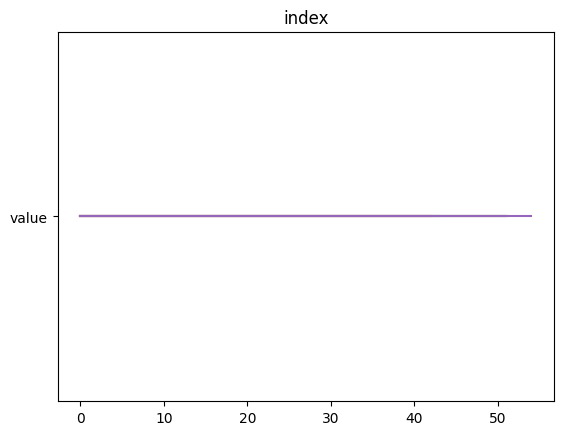

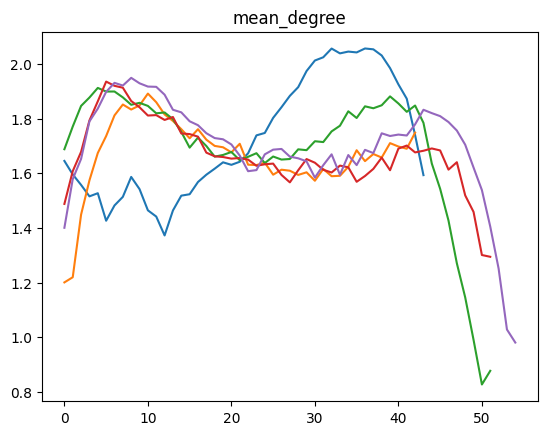

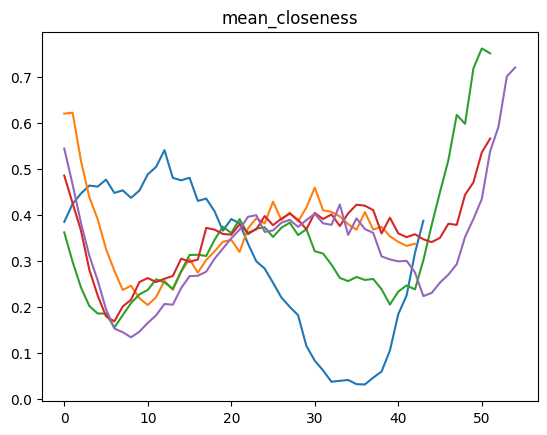

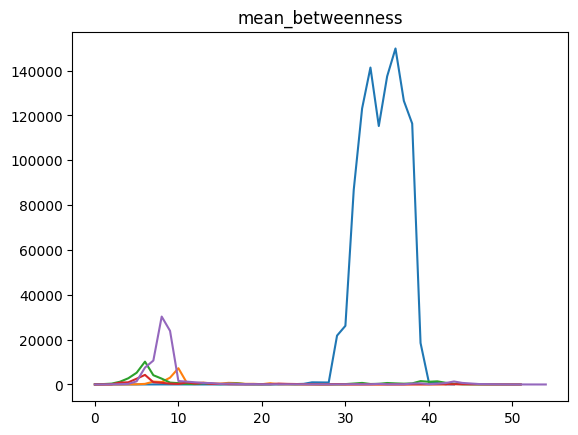

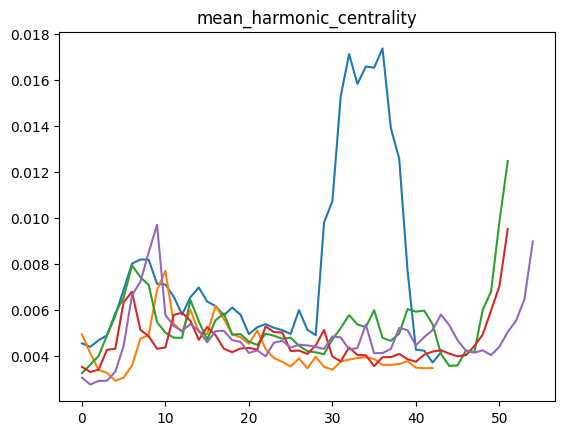

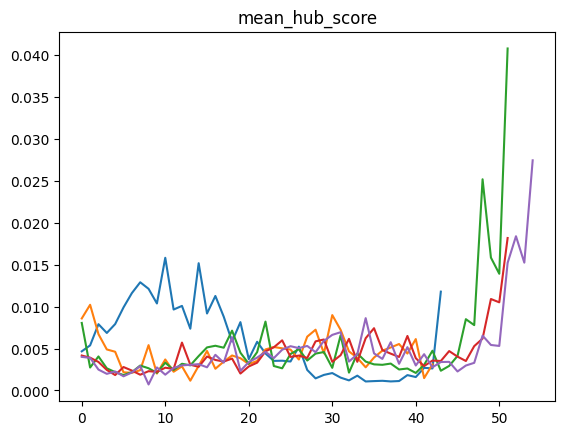

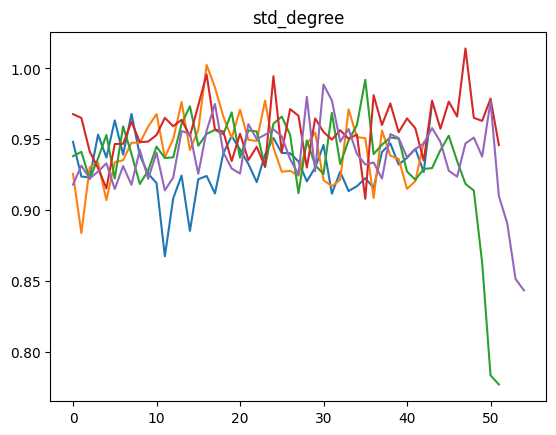

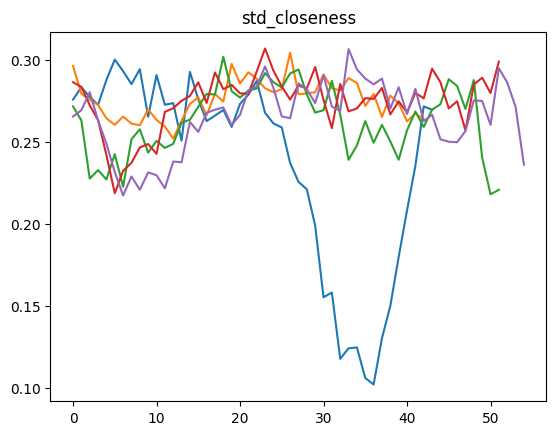

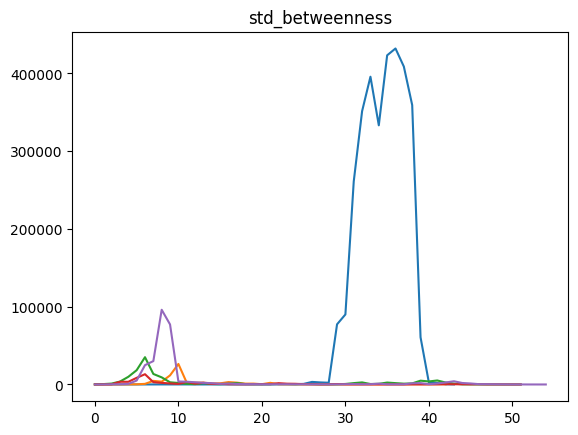

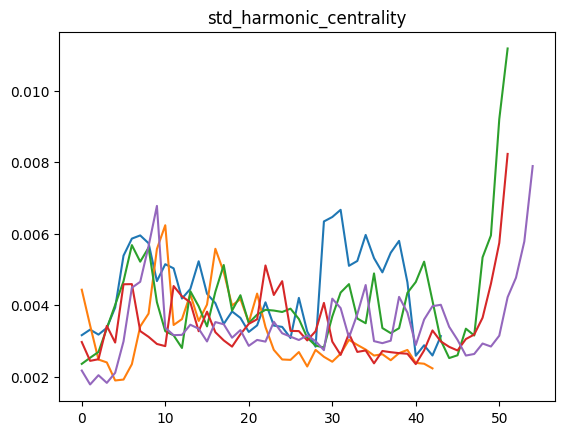

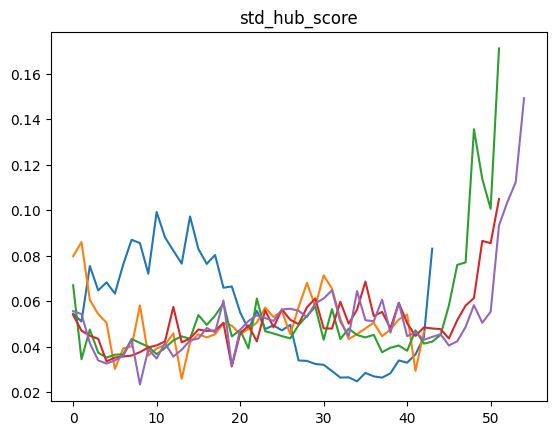

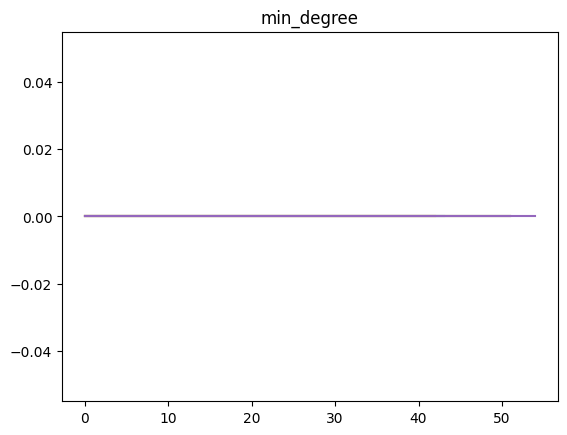

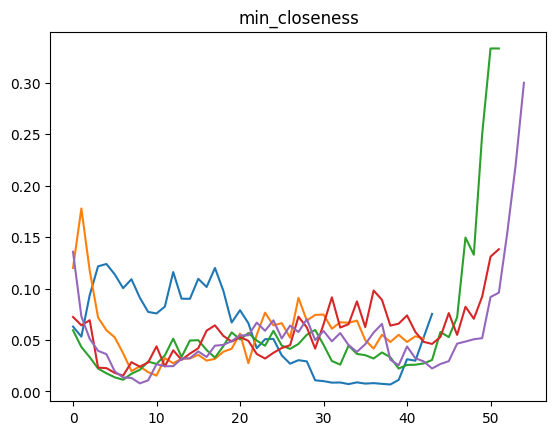

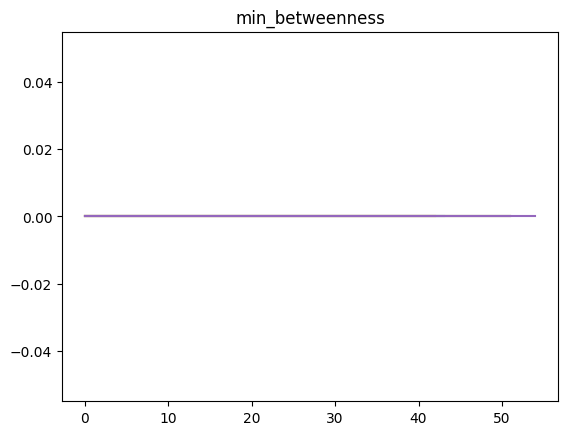

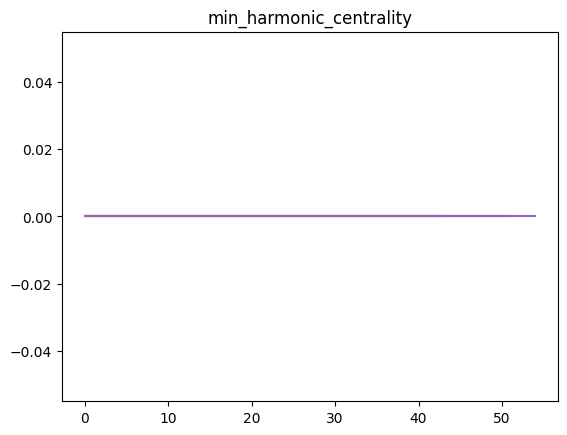

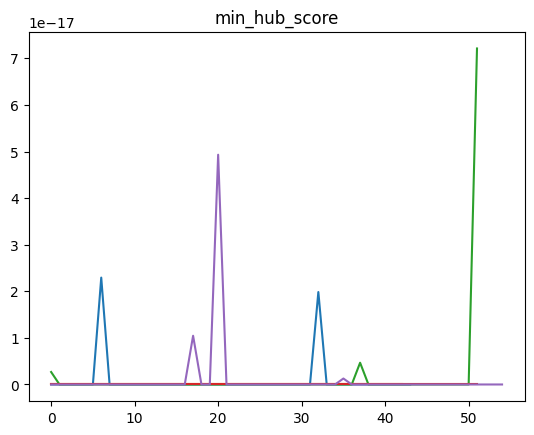

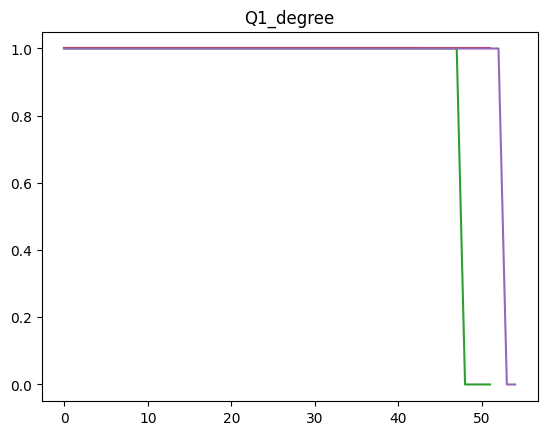

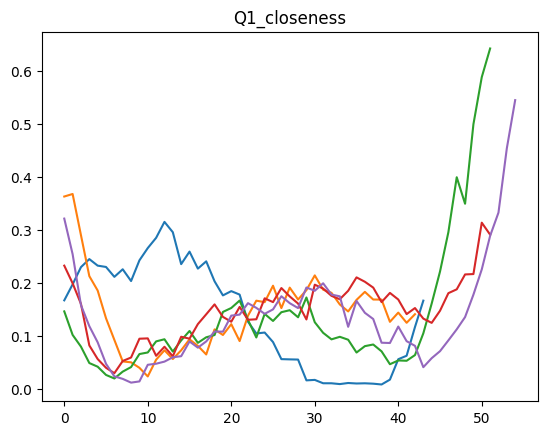

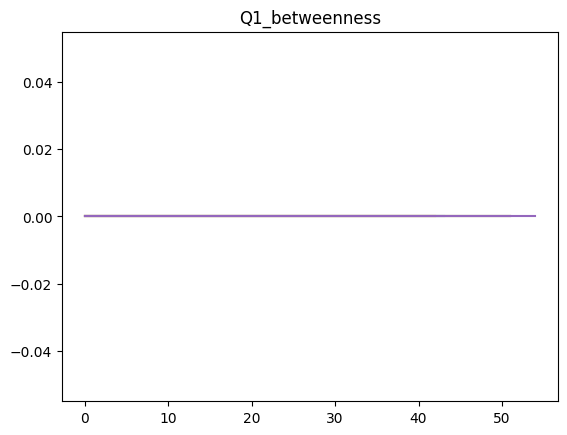

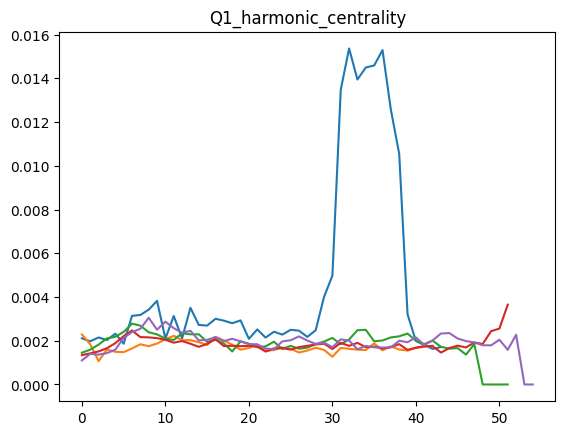

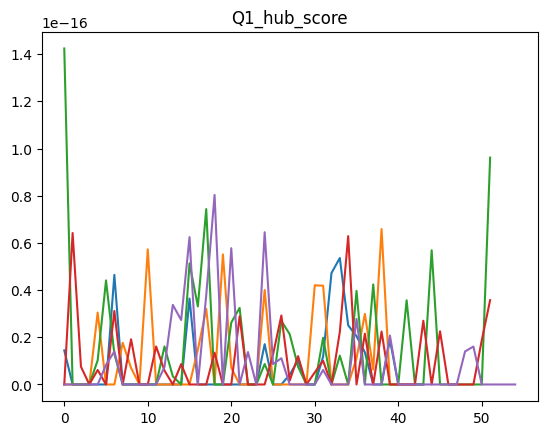

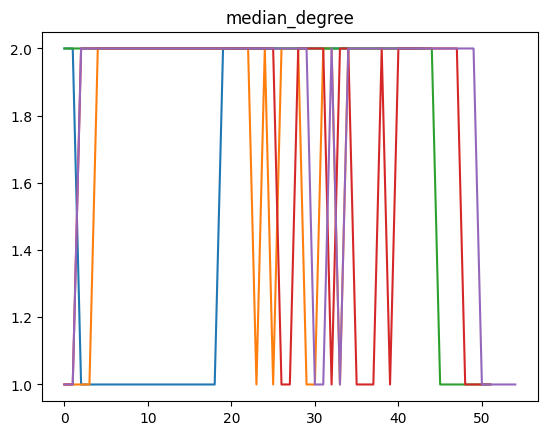

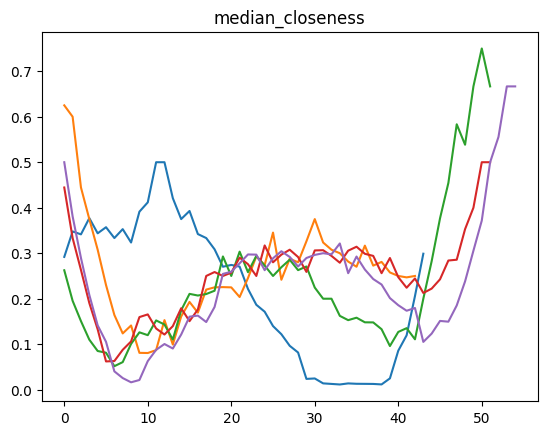

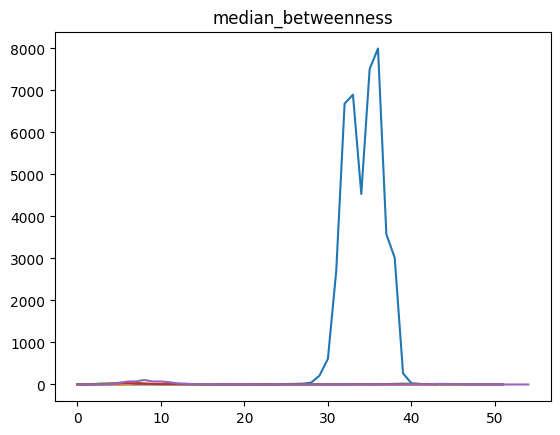

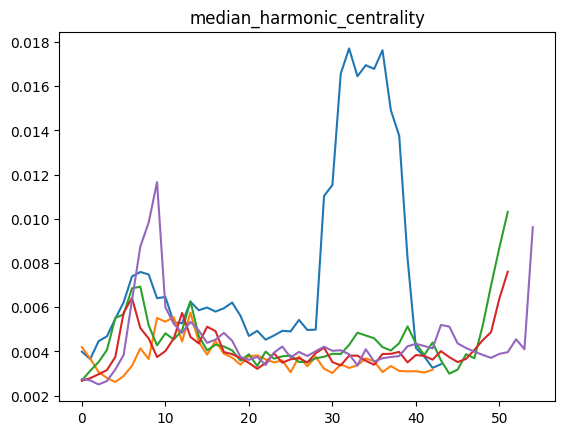

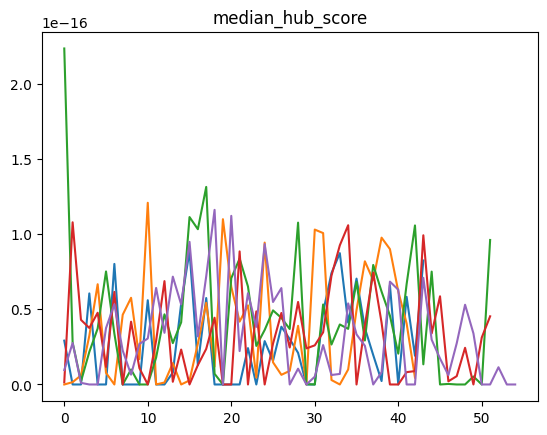

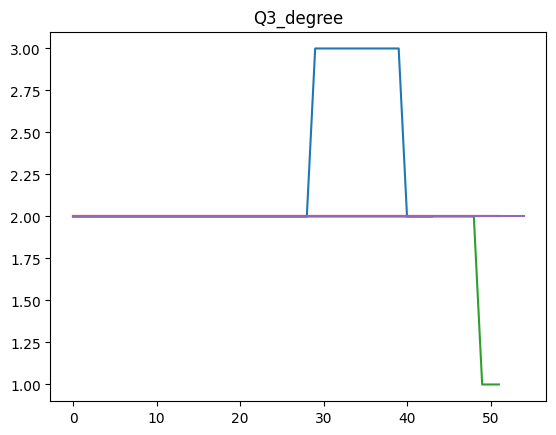

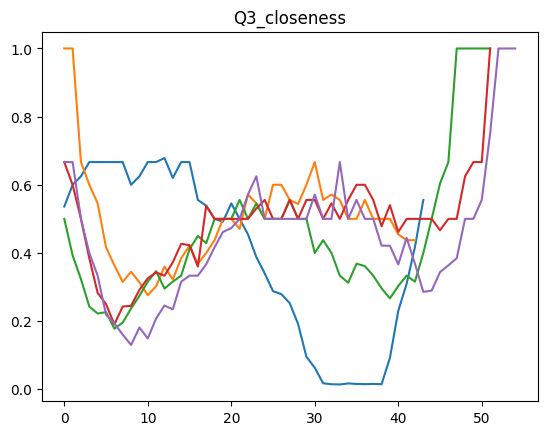

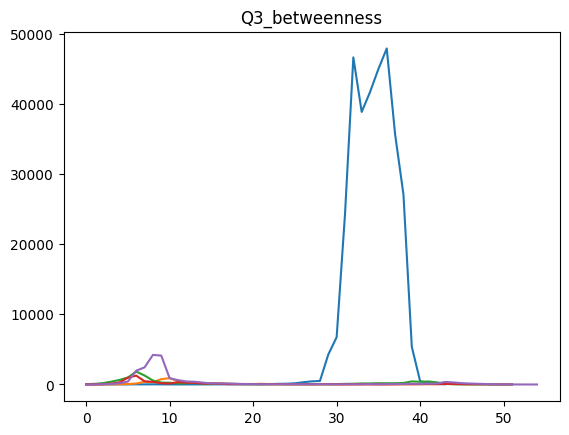

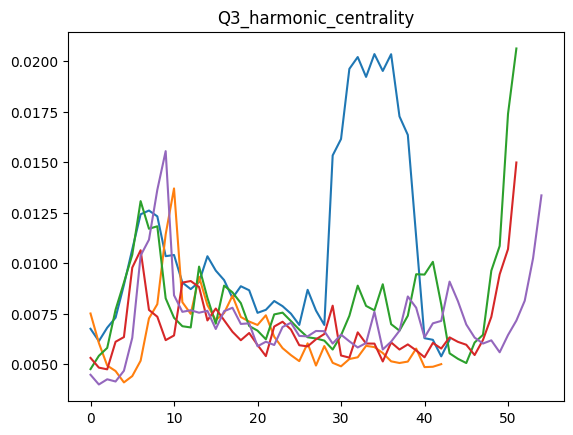

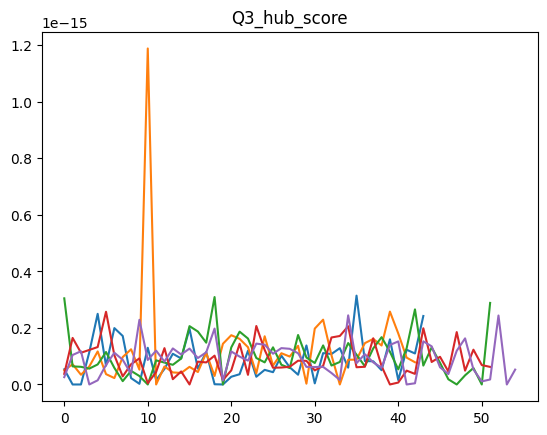

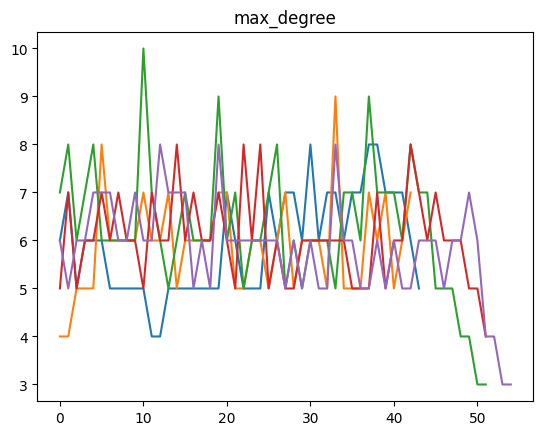

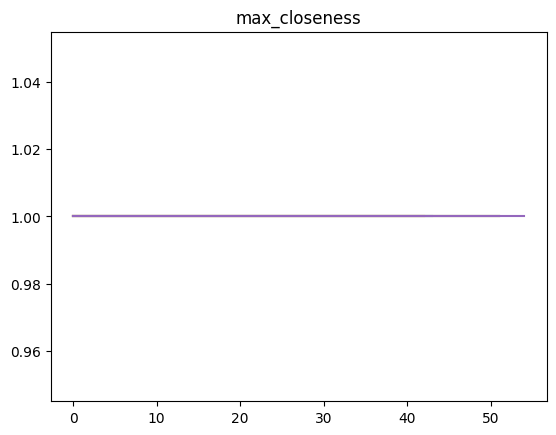

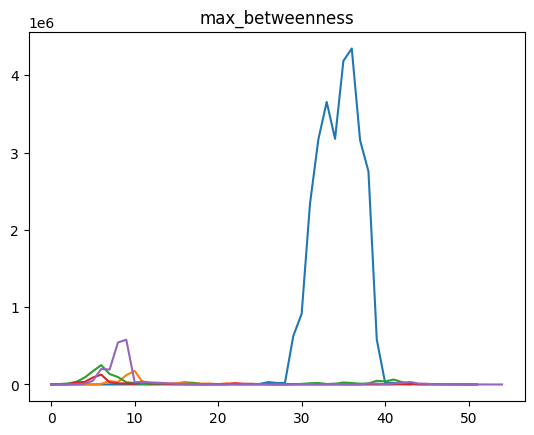

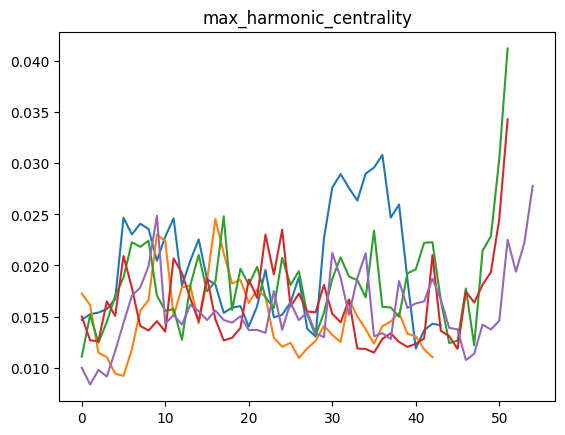

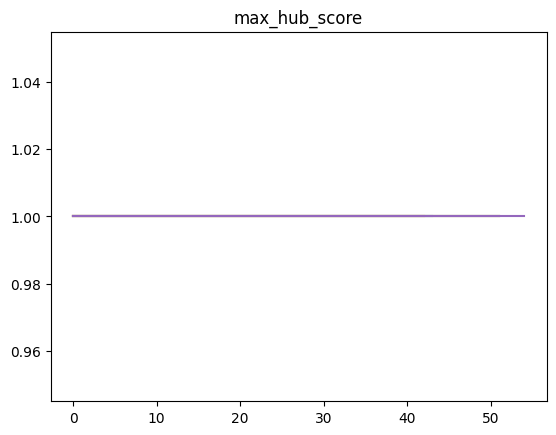

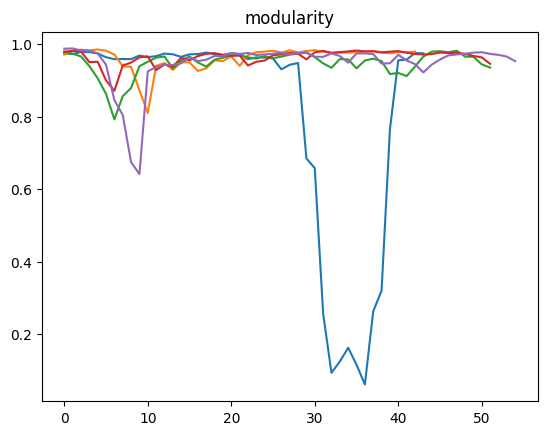

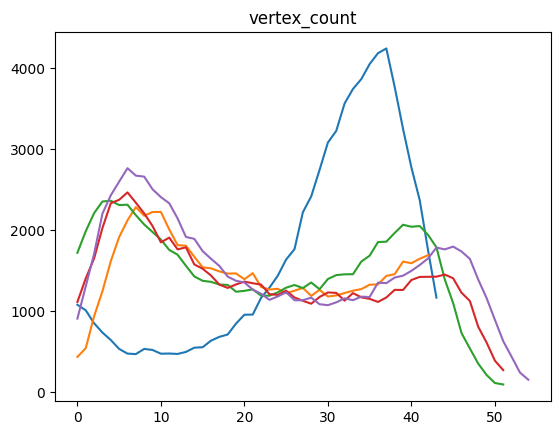

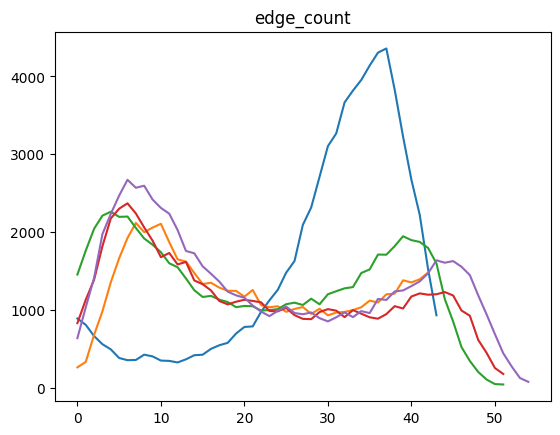

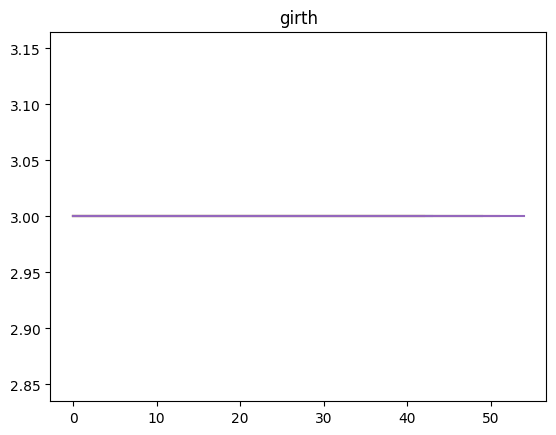

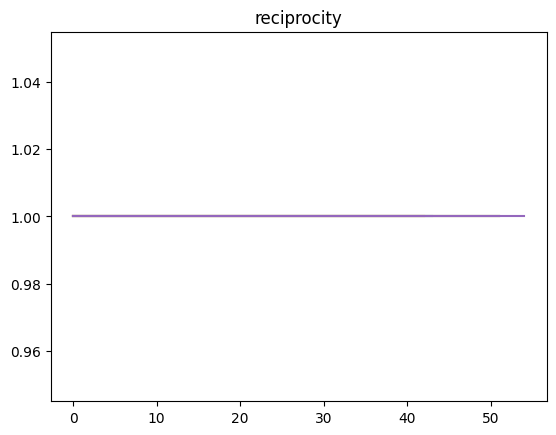

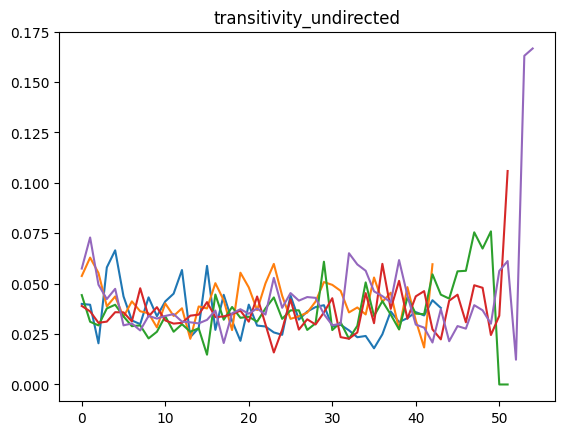

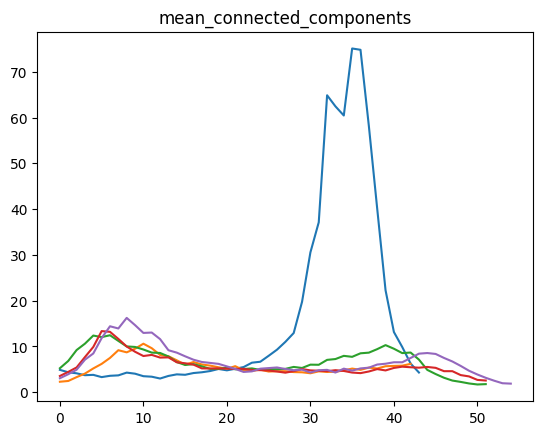

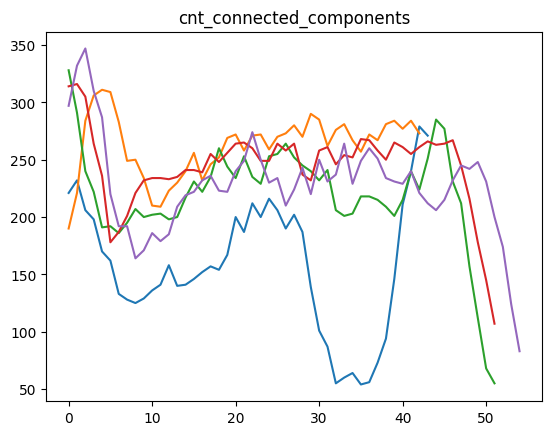

In [30]:
for feature_name in feature_names:
    plt.figure()
    for i in range(len(all_network_statistics)):
        df = pd.concat(all_network_statistics[i])
        plt.plot(df_all_network_statistics[i][feature_name])
    plt.title(feature_name)

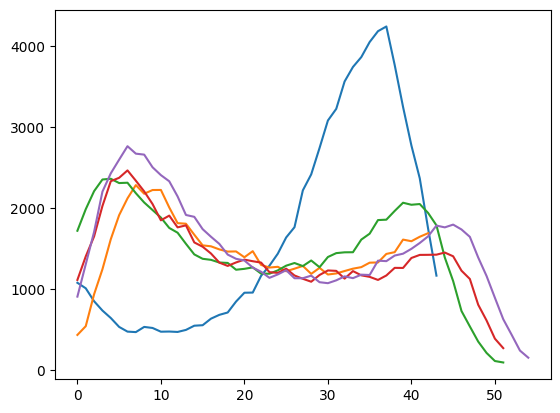

In [31]:
for i in range(len(all_branching)):
    plt.plot(all_branching[i])

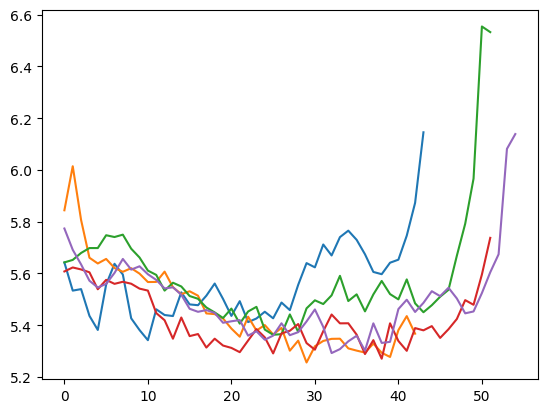

In [32]:
for i in range(len(all_mean_width)):
    plt.plot(all_mean_width[i])

<AxesSubplot: >

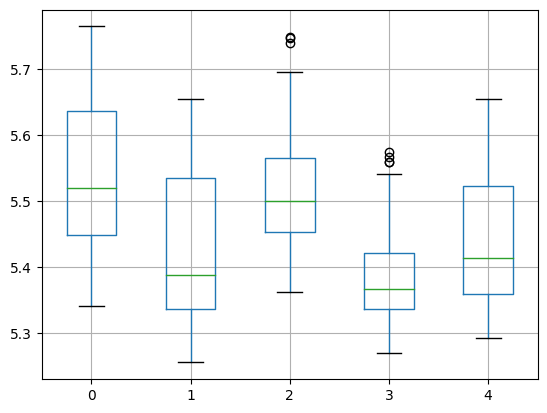

In [33]:
df = pd.DataFrame(all_mean_width).T
df.loc[5:40].boxplot()

In [34]:
import scipy.stats as stats
df_all_mean_width = pd.DataFrame(all_mean_width).T
df_all_mean_width = df_all_mean_width.loc[5:40]
all_mean_widths_tuple = df_all_mean_width[0], df_all_mean_width[1], df_all_mean_width[2], df_all_mean_width[3], df_all_mean_width[4]
fvalue, pvalue = stats.f_oneway(*all_mean_widths_tuple)
print(pvalue)

group_names = list(map(lambda x: x[1], data))
widths = zip(group_names, all_mean_widths_tuple)
mean_widths = []
group_labels = []
for group_name, mean_width in widths:
    mean_widths += mean_width.tolist()
    group_labels += [group_name] * len(mean_width)
df_widths = pd.DataFrame({'width': mean_widths, 'labels': group_labels})

from statsmodels.stats.multicomp import pairwise_tukeyhsd
m_comp = pairwise_tukeyhsd(endog=df_widths['width'], groups=df_widths['labels'], alpha=0.05)
print(m_comp)

2.3680274608279482e-09
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   old  young   0.0978   0.0 0.0565 0.1391   True
-------------------------------------------------


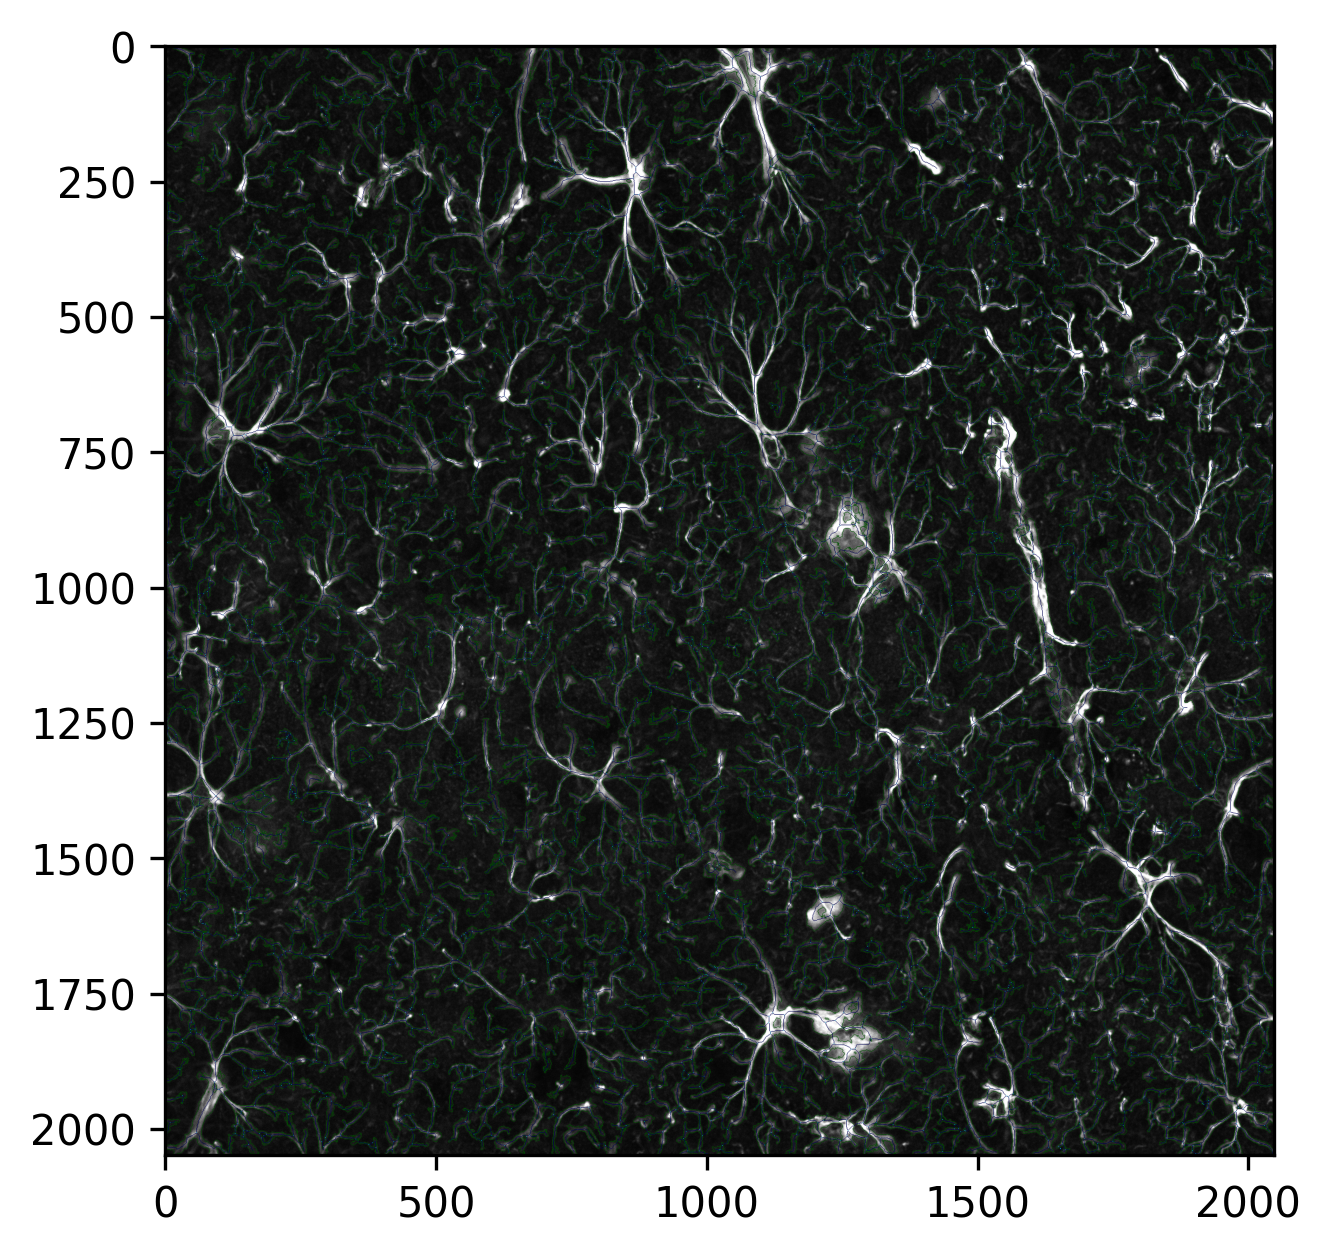

In [35]:
mask, skeleton, dist, forest_img = all_data[0][35]
plt.figure(dpi=300)
plt.imshow(forest_img)

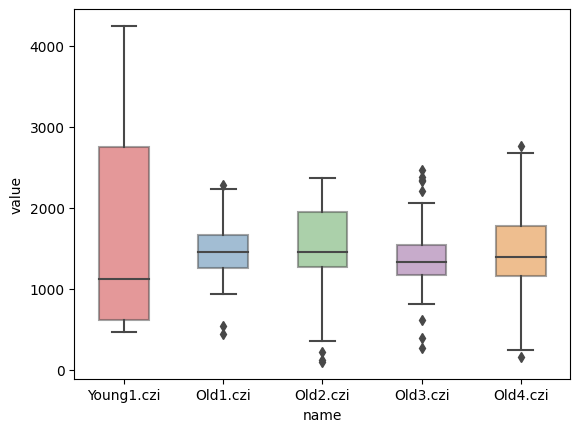

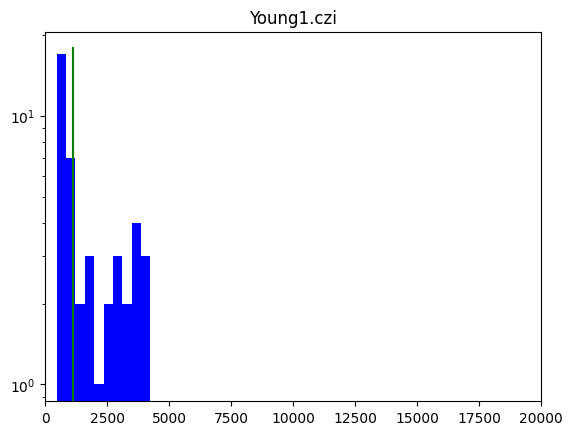

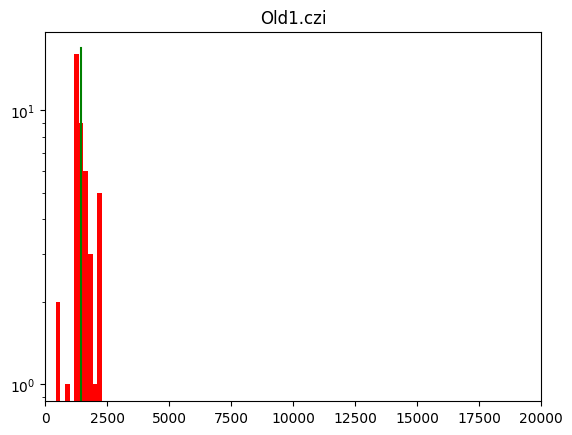

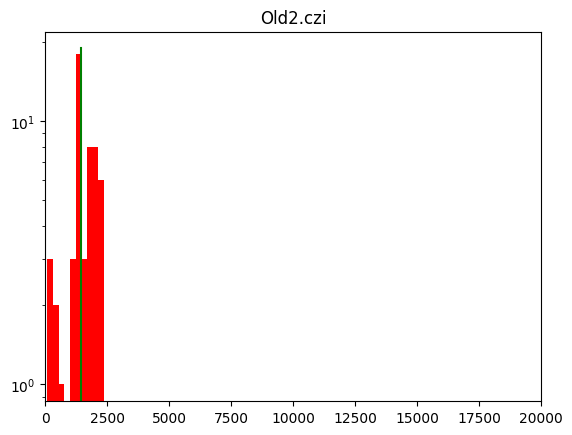

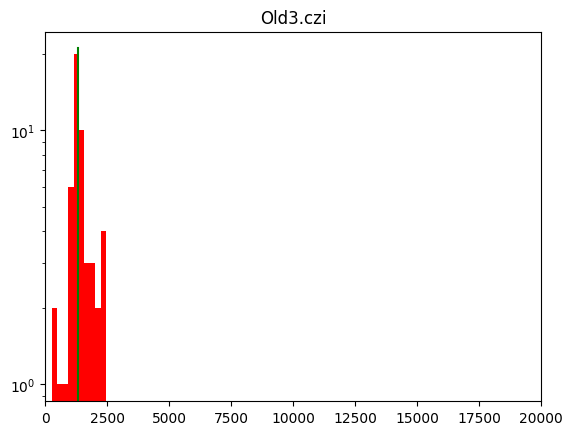

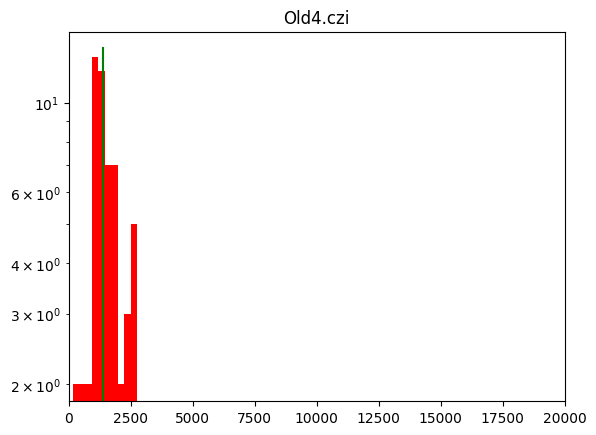

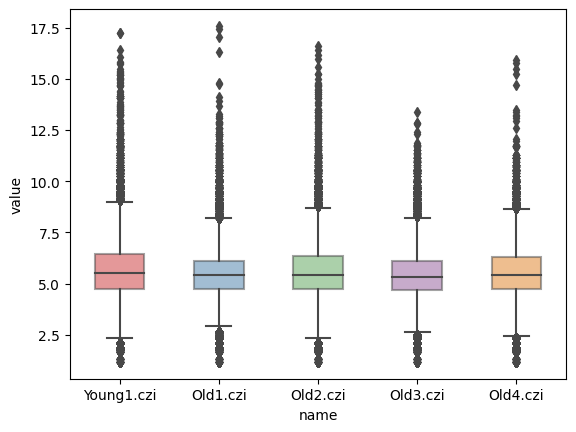

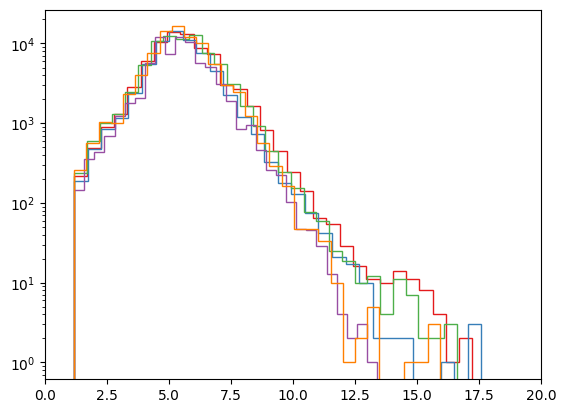

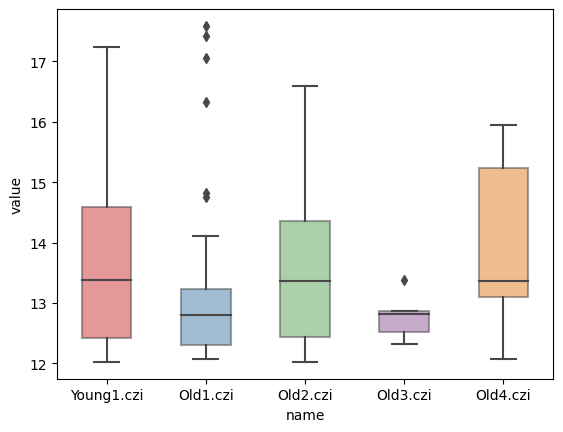

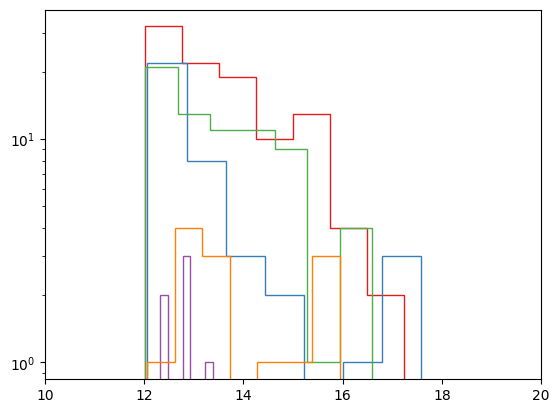

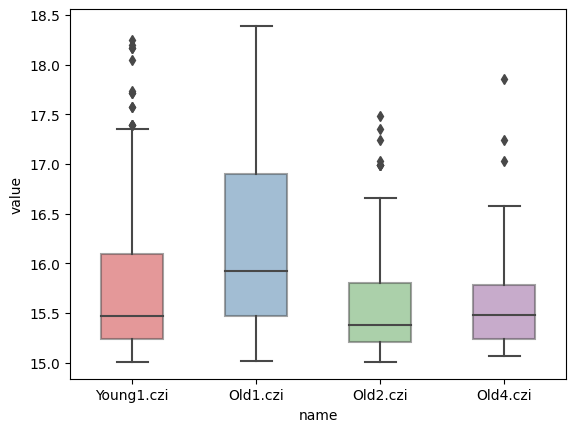

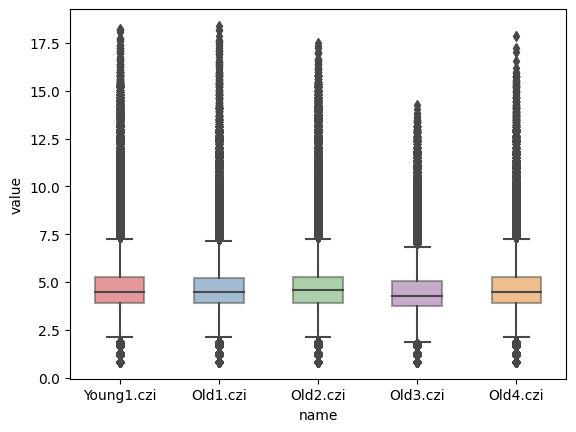

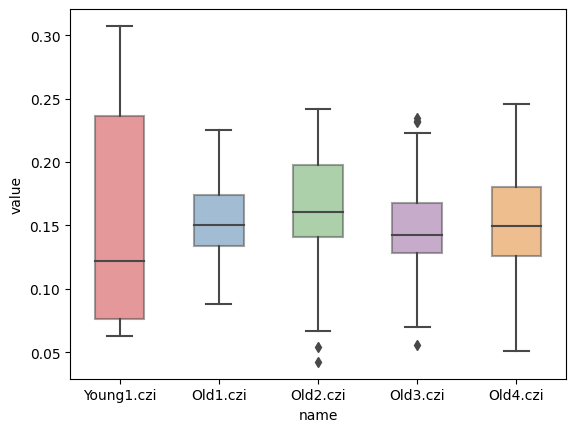

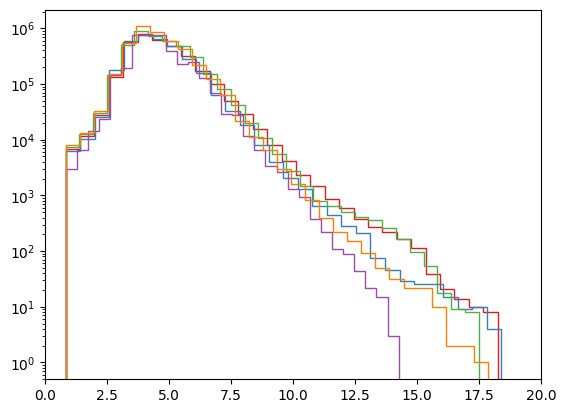

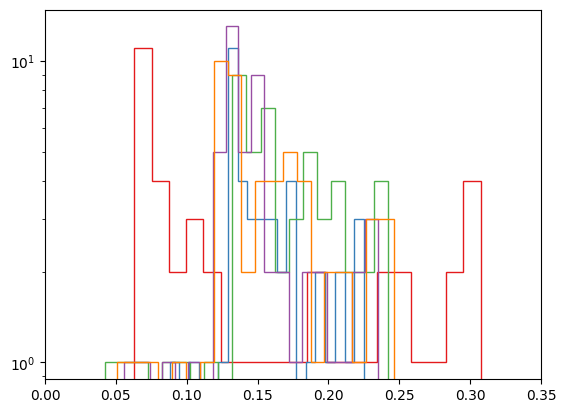

In [36]:
def make_boxplot(data_info, all_distances):
    df_data = pd.DataFrame()
    for (cur_name, cur_type), cur_data in zip(data_info, all_distances):
        df_data = df_data.append(pd.DataFrame({'value': cur_data, 'name': cur_name}), ignore_index=True)
    import seaborn as sns
    fig = plt.figure()
    ax = plt.gca()
    sns.set_palette(sns.color_palette("Set1", 12))
    bx = sns.boxplot(x = 'name', y = 'value', data = df_data, width = 0.5, boxprops=dict(alpha=.5), ax = ax)
    
def make_hist(data_info, all_distances, xlim, bins = 20, ylogscale = True):
    import seaborn as sns
    fig = plt.figure()
    for (cur_name, cur_type), cur_data in zip(data_info, all_distances):
        #plt.hist(cur_data, color = 'b' if cur_type == 'young' else 'r', bins = bins)
        #sns.kdeplot(cur_data, label = cur_name, bw = 0.5)
        plt.hist(cur_data, bins = bins, label = cur_name, histtype = 'step')
        #mn = np.median(cur_data)
        #plt.plot([mn, mn], plt.ylim(), 'g')
        #plt.title(cur_name)
        plt.xlim(xlim)
        if ylogscale:
            plt.yscale('log')

def make_hist_many(data_info, all_distances, xlim, bins = 20, ylogscale = True):
    import seaborn as sns
    
    for (cur_name, cur_type), cur_data in zip(data_info, all_distances):
        fig = plt.figure()
        plt.hist(cur_data, color = 'b' if cur_type == 'young' else 'r', bins = bins)
        mn = np.median(cur_data)
        plt.plot([mn, mn], plt.ylim(), 'g')
        plt.title(cur_name)
        plt.xlim(xlim)
        if ylogscale:
            plt.yscale('log')

make_boxplot(data, all_branching)
make_hist_many(data, all_branching, xlim = [0, 2e4], bins = 10)
#make_hist_many(data, all_area, xlim = [0, 0.35], bins = 20)
            
make_boxplot(data, all_branching_width)
make_hist(data, all_branching_width, xlim = [0, 20], bins = 30, ylogscale = True)

make_boxplot(data,  list(map(lambda x: x[x > 12], all_branching_width)))
make_hist(data, list(map(lambda x: x[x > 12], all_branching_width)), xlim = [10, 20], bins = 7, ylogscale = True)

#make_boxplot(data, all_branching)

make_boxplot(data, list(map(lambda x: x[x > 15], all_distances)))

make_boxplot(data, all_distances)
make_boxplot(data, all_area)
make_hist(data, all_distances, xlim = [0, 20], bins = 30, ylogscale = True)
make_hist(data, all_area, xlim = [0, 0.35], bins = 20)
